In [75]:
!pip install pyreaddbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyreaddbc: filename=pyreaddbc-1.2.0-cp310-cp310-manylinux_2_35_x86_64.whl size=89795 sha256=f105d408d4854acdcf4f4d0f48efbe4181be98a2737825f3332f3005b840224d
  Stored in directory: /root/.cache/pip/wheels/44/9c/3c/0b2efbb6180556cf083065c5c0368bb38a26c83dbd5f9a9ba1
Successfully built pyreaddbc


In [32]:
!pip install dbfread

In [33]:
import pandas as pd
from dbfread import DBF

df_list = []

for i in range(10, 23):
    file = DBF(f'DOPB20{i}.dbf', load=True)
    print(file)
    df = pd.DataFrame(file)
    df_list.append(df)

<loaded DBF table 'DOPB2010.dbf'>
<loaded DBF table 'DOPB2011.dbf'>
<loaded DBF table 'DOPB2012.dbf'>
<loaded DBF table 'DOPB2013.dbf'>
<loaded DBF table 'DOPB2014.dbf'>
<loaded DBF table 'DOPB2015.dbf'>
<loaded DBF table 'DOPB2016.dbf'>
<loaded DBF table 'DOPB2017.dbf'>
<loaded DBF table 'DOPB2018.dbf'>
<loaded DBF table 'DOPB2019.dbf'>
<loaded DBF table 'DOPB2020.dbf'>
<loaded DBF table 'DOPB2021.dbf'>
<loaded DBF table 'DOPB2022.dbf'>


In [34]:
df_concat = pd.DataFrame()

for df in df_list:
    df_concat = pd.concat([df_concat, df])

len(df_list)

13

In [35]:
from numpy import nan

columns = ['DTOBITO','CONTADOR','OCUP', 'HORAOBITO','NATURAL','CODMUNNATU','DTNASC','IDADE','SEXO','RACACOR','ESTCIV','ESC2010','CODMUNRES','LOCOCOR','CODMUNOCOR','CIRCOBITO','FONTE', 'TIPOBITO']

df_hom = (df_concat
 .filter(columns)
 .drop_duplicates()
 .replace('', nan)
 .query('CIRCOBITO == "3"')
 .query('TIPOBITO == "2"')
 .astype({'ESC2010': float})
 .reset_index().drop('index', axis=1)
)

df_hom['DTOBITO'] = df_hom['DTOBITO'].apply(lambda x: x[-4:])

In [36]:
qtd_linhas = df_concat.shape[0]

(df_hom
 .query('ESC2010 == 9').shape[0] # possivel limitação devido ao 9 == ignorado
)

4353

In [37]:
(df_hom
 .groupby('ESC2010', dropna=False)['CONTADOR'].count()
 #.apply(lambda x: (x/qtd_linhas) * 100).sum()
)

,CONTADOR
ESC2010,
0.0,335
1.0,2009
2.0,1319
3.0,505
4.0,43
5.0,85
9.0,4353
NaN,8189


<Axes: xlabel='LOCOCOR'>

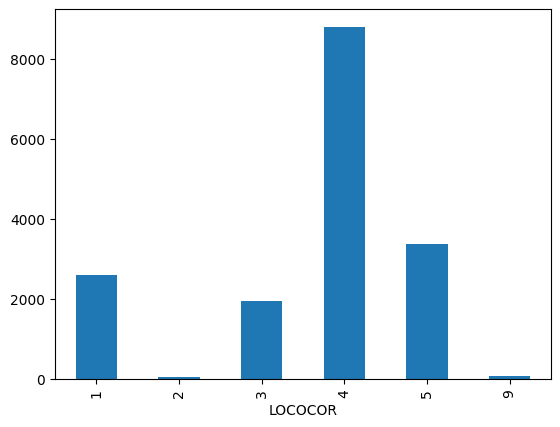

In [38]:
df_hom.groupby('LOCOCOR')['CONTADOR'].count().plot(kind='bar') # 4 - via pública é o maior

In [39]:
df_hom.groupby('FONTE', dropna=False)['CONTADOR'].count()#.plot(kind='bar')#.sum()

,CONTADOR
FONTE,
1,11530
2,61
3,18
4,118
9,151
NaN,4960


In [40]:
(df_hom
 .reset_index()
 .drop('index', axis=1)
 .query("IDADE.str.startswith('4') == False")
 .groupby('IDADE')['CONTADOR'].count().sum()
) # 54 não tem idade definida (indigente ou cpf perdido...)

54

In [41]:
#df_hom.query("NATURAL.str.startswith('8') and NATURAL != '999' and NATURAL.str.endswith('25') == False")#.groupby('NATURAL')['CONTADOR'].count()

<Axes: xlabel='ESC2010'>

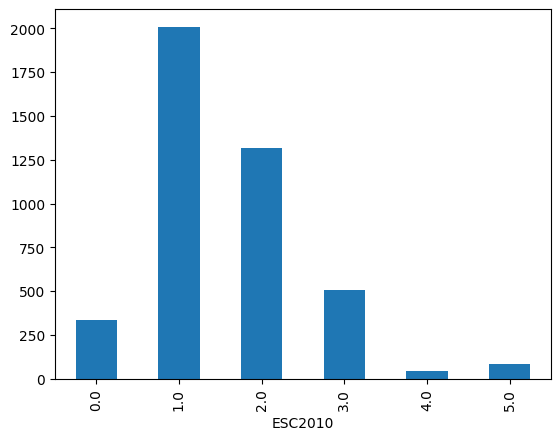

In [42]:
df_hom.groupby('ESC2010')['CONTADOR'].count().drop(9).plot(kind='bar')

In [43]:
df_hom.groupby('DTOBITO')['CONTADOR'].count()

,CONTADOR
DTOBITO,
2010,1364
2011,1555
2012,1460
2013,1511
2014,1521
2015,1487
2016,1301
2017,1314
2018,1201


# Leitura dos dados das populações

In [45]:
pop0120 = pd.read_excel('pop0120.xls', header=4).iloc[15].drop('Unidades da Federação').astype(int)
pop0120

,15
2001,3468594
2002,3494893
2003,3518595
2004,3568350
2005,3595886
2006,3623215
2007,3641397
2008,3742606
2009,3769977
2010,3766834


In [46]:
pop2021 = (pd.read_excel('pop2021.xls').iloc[15].rename({'Unnamed: 2': '2021'})
.drop(['ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2021', 'Unnamed: 1'])).astype(int)
pop2021

,15
2021,4059905


In [47]:
pop2022 = pd.read_excel('pop2022.xlsx', header=2).drop('Unnamed: 0', axis=1).dropna(subset='COD. UF').query('UF == "PB"').groupby('UF')['POP. TOTAL'].sum().rename({'PB': 2022}).astype(int)
pop2022

,POP. TOTAL
UF,
2022,3974687


# Juntando dados IBGE com SIM

In [48]:
pop = pd.concat([pop0120, pop2021, pop2022])
pop = pop.reset_index().rename(columns={'index': 'DTOBITO',0: 'POPULACAO'}).drop(range(0, 9)).reset_index().drop('index', axis=1)
taxa_hom = df_hom.groupby('DTOBITO')['CONTADOR'].count().reset_index().rename(columns={'CONTADOR': 'HOMICIDIOS'})

In [80]:
#display(pop)
#display(taxa_hom)
taxa_hom = taxa_hom.merge(pop, how='outer', left_index=True, right_index=True).drop('DTOBITO_y', axis=1).rename(columns={'DTOBITO_x': 'ANO'})
taxa_hom_esc = df_hom_base.query('ESC2010 <= 2').groupby('DTOBITO')['CONTADOR'].count().reset_index().rename(columns={'CONTADOR': 'HOMICIDIOS'})
taxa_hom_esc = taxa_hom_esc.merge(pop, how='outer', left_index=True, right_index=True).drop('DTOBITO_y', axis=1).rename(columns={'DTOBITO_x': 'ANO'})

In [83]:
taxa_hom_esc

,ANO,HOMICIDIOS,POPULACAO
0,2012,462.0,3766834
1,2013,509.0,3791315
2,2014,419.0,3815171
3,2015,325.0,3914421
4,2016,195.0,3943885
5,2017,215.0,3972202
6,2018,214.0,3999415
7,2019,168.0,4025558
8,2020,298.0,3996496
9,2021,458.0,4018127


# Calculando taxa de homicídio

In [84]:
hom = taxa_hom.assign(TAXA=lambda x: round((x['HOMICIDIOS']/x['POPULACAO']) * 100000, 3))
hom_esc = taxa_hom_esc.assign(TAXA=lambda x: round((x['HOMICIDIOS']/x['POPULACAO']) * 100000, 3))

<Axes: xlabel='ANO'>

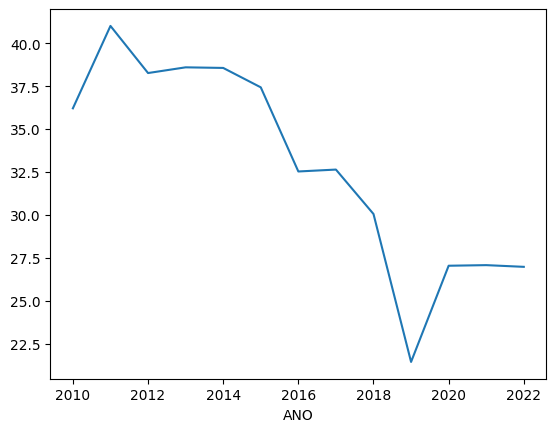

In [52]:
hom.groupby('ANO')['TAXA'].sum().plot()

<Axes: xlabel='ANO'>

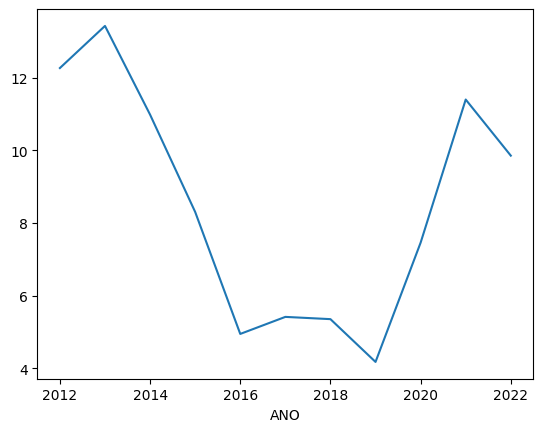

In [88]:
hom_esc.groupby('ANO')['TAXA'].sum().plot()

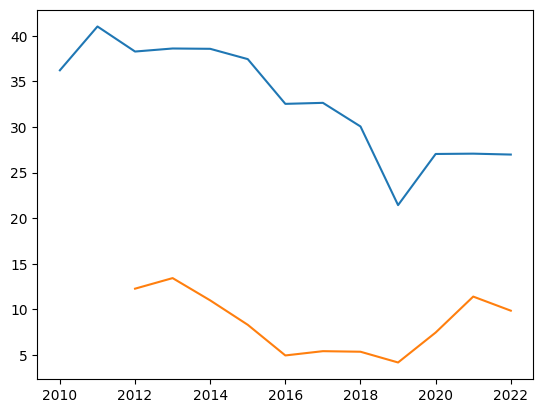

In [96]:
import matplotlib.pyplot as plt

hom = hom.astype({'ANO': int})
hom_esc = hom_esc.dropna().astype({'ANO': int})

plt.plot(hom['ANO'], hom['TAXA'])
plt.plot(hom_esc['ANO'], hom_esc['TAXA'])

plt.show()

In [98]:
hom

,ANO,HOMICIDIOS,POPULACAO,TAXA
0,2010,1364,3766834,36.211
1,2011,1555,3791315,41.015
2,2012,1460,3815171,38.268
3,2013,1511,3914421,38.601
4,2014,1521,3943885,38.566
5,2015,1487,3972202,37.435
6,2016,1301,3999415,32.530
7,2017,1314,4025558,32.641
8,2018,1201,3996496,30.051
9,2019,861,4018127,21.428


In [53]:
std_hom = hom.filter(['HOMICIDIOS', 'TAXA'])['TAXA'].std()

# Lendo dados do IPEA para comparação

In [58]:
taxa_ipea = pd.read_csv('taxa-homicidios-2010-01--01-2022-01--01.csv', sep=';').rename(columns={'período': 'ANO', 'valor': 'TAXA'}).filter(['ANO', 'TAXA'])
std_ipea = taxa_ipea['TAXA'].std()

round(abs(std_hom - std_ipea), 3)

0.106

# Analisando dados pela escolaridade

In [59]:
dist_esc = df_hom.groupby('ESC2010')['CONTADOR'].count()
dist_esc

,CONTADOR
ESC2010,
0.0,335
1.0,2009
2.0,1319
3.0,505
4.0,43
5.0,85
9.0,4353


In [60]:
df_hom_base = df_hom.query('ESC2010 <= 3') # filtrando por educação basica (ef1, ef2, em)
df_hom_base

,DTOBITO,CONTADOR,OCUP,HORAOBITO,NATURAL,CODMUNNATU,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC2010,CODMUNRES,LOCOCOR,CODMUNOCOR,CIRCOBITO,FONTE,TIPOBITO
2920,2012,1429,621005,0510,NaN,NaN,20021977,435,1,4,1,2.0,251680,5,292400,3,1,2
2933,2012,1484,NaN,2230,NaN,NaN,10021987,424,1,4,1,1.0,251010,4,251010,3,NaN,2
2934,2012,1487,717020,2300,NaN,NaN,01061979,432,1,4,5,1.0,250400,4,250400,3,NaN,2
2937,2012,1490,622020,NaN,NaN,NaN,10091990,421,1,1,1,3.0,251510,5,251510,3,NaN,2
2947,2012,1639,622020,NaN,NaN,NaN,03071995,416,1,4,9,2.0,250760,4,250760,3,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16818,2022,1534790,NaN,1800,825,251370,15022000,422,1,4,1,2.0,251370,5,250750,3,1,2
16821,2022,1534796,NaN,0100,825,250750,21111994,427,1,4,1,2.0,250180,4,250180,3,1,2
16828,2022,1539848,NaN,0500,826,260765,04071977,445,2,4,1,1.0,251370,4,251370,3,1,2
16835,2022,1541331,NaN,NaN,827,270350,13061983,439,2,4,1,2.0,251370,5,251370,3,NaN,2


Verificando de acordo com as informações de identificação e comparando (raça, idade, situação conjugal, etc.)

idade

In [61]:
df_hom_base = df_hom_base.query('IDADE.str.startswith("4")') # filtrando por idade em anos e eliminando os que tem 999 ou bebês
df_hom_base['IDADE'] = df_hom_base['IDADE'].str[1:]

df_hom = df_hom.query('IDADE.str.startswith("4")') # filtrando por idade em anos e eliminando os que tem 999 ou bebês
df_hom['IDADE'] = df_hom['IDADE'].str[1:]

<ipython-input-61-f920ebba1f93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hom_base['IDADE'] = df_hom_base['IDADE'].str[1:]


6 a 10 anos -> fundamental 1

11 a 14 anos -> fundamental 2

15 a 17 anos -> medio

lei de diretrizes

In [62]:
df_hom = df_hom.astype({'IDADE': int})
df_hom_base = df_hom_base.astype({'IDADE': int})

# não temos o dado da escolaridade que está cursando, portanto pegamos a próxima fase, que indica baixa escolaridade

# para fundamental 1:
df_hom_base.query('IDADE > 10 and IDADE <= 18 and ESC2010 <= 0')

# para fundamental 2:
df_hom_base.query('IDADE > 14 and IDADE <= 18 and ESC2010 <= 1')

# para medio:
# grupo 1 -> 18-24
df_hom_base_18_total = df_hom.query('18 <= IDADE <= 24')['IDADE'].count()
df_hom_base_18 = df_hom_base.query('18 <= IDADE <= 24 and ESC2010 <= 2')['IDADE'].count() # 1088 casos

# grupo 2 -> 25-34
df_hom_base_25_total = df_hom.query('25 <= IDADE <= 34')['IDADE'].count()
df_hom_base_25 = df_hom_base.query('25 <= IDADE <= 34 and ESC2010 <= 2')['IDADE'].count() # 1084

# grupo 3 -> 35-44
df_hom_base_35_total = df_hom.query('35 <= IDADE <= 44')['IDADE'].count()
df_hom_base_35 = df_hom_base.query('35 <= IDADE <= 44 and ESC2010 <= 2')['IDADE'].count() # 581

# grupo 4 -> 45-54
df_hom_base_45_total = df_hom.query('45 <= IDADE <= 54')['IDADE'].count()
df_hom_base_45 = df_hom_base.query('45 <= IDADE <= 54 and ESC2010 <= 2')['IDADE'].count() # 267

# grupo 5 -> 55-64
df_hom_base_55_total = df_hom.query('55 <= IDADE <= 64')['IDADE'].count()
df_hom_base_55 = df_hom_base.query('55 <= IDADE <= 64 and ESC2010 <= 2')['IDADE'].count() # 114

# grupo 6 -> 65 =>
df_hom_base_65_total = df_hom.query('IDADE >= 65')['IDADE'].count()
df_hom_base_65 = df_hom_base.query('IDADE >= 65 and ESC2010 <= 2')['IDADE'].count() # 62

In [63]:
df_hom.query('18 <= IDADE <= 24')

,DTOBITO,CONTADOR,OCUP,HORAOBITO,NATURAL,CODMUNNATU,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC2010,CODMUNRES,LOCOCOR,CODMUNOCOR,CIRCOBITO,FONTE,TIPOBITO
1,2010,205,622020,1700,825,NaN,02021987,23,1,4,2,NaN,250560,4,251450,3,9,2
15,2010,2143,768320,2100,NaN,NaN,27071990,20,1,4,1,NaN,251080,5,251080,3,1,2
18,2010,2625,NaN,NaN,825,NaN,31101991,18,1,4,9,NaN,250630,5,250630,3,1,2
19,2010,2627,NaN,0700,825,NaN,NaN,21,1,4,1,NaN,250600,5,250600,3,1,2
20,2010,3025,NaN,1620,NaN,NaN,28021987,22,1,4,1,NaN,250240,4,251380,3,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16826,2022,1535498,914405,2125,825,250750,23102001,20,1,4,NaN,NaN,250750,1,250750,3,NaN,2
16829,2022,1539850,NaN,NaN,825,250750,16022003,19,2,4,9,9.0,250730,5,250730,3,1,2
16830,2022,1539852,NaN,1930,825,250750,14052002,20,1,4,1,NaN,250750,4,250750,3,NaN,2
16832,2022,1540588,NaN,1540,825,251290,28031999,23,1,4,1,NaN,250140,4,250140,3,1,2


In [64]:
df_hom_base_18_taxa = df_hom_base_18/df_hom_base_18_total
df_hom_base_25_taxa = df_hom_base_25/df_hom_base_25_total
df_hom_base_35_taxa = df_hom_base_35/df_hom_base_35_total
df_hom_base_45_taxa = df_hom_base_45/df_hom_base_45_total
df_hom_base_55_taxa = df_hom_base_55/df_hom_base_55_total
df_hom_base_65_taxa = df_hom_base_65/df_hom_base_65_total

In [65]:
idade_series = pd.Series({'18-25': df_hom_base_18, '25-35': df_hom_base_25, '35-45': df_hom_base_35, '45-55': df_hom_base_45, '55-65': df_hom_base_55,'65+': df_hom_base_65})

In [66]:
idade_series_taxa = pd.Series({'18-25': df_hom_base_18_taxa, '25-35': df_hom_base_25_taxa, '35-45': df_hom_base_35_taxa, '45-55': df_hom_base_45_taxa, '55-65': df_hom_base_55_taxa,'65+': df_hom_base_65_taxa})

<Axes: >

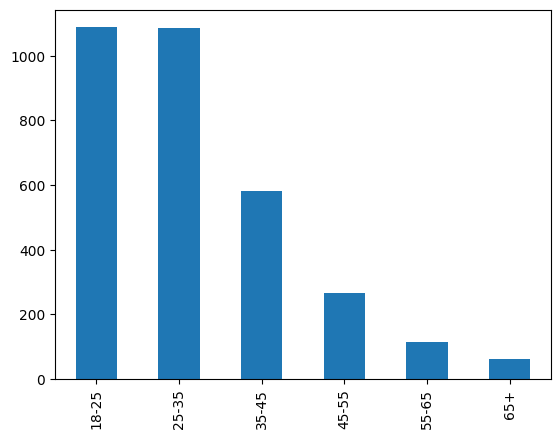

In [67]:
idade_series.plot(kind='bar') # a maior parte das vitimas tem entre 18-35 anos

In [68]:
idade_series_taxa #.plot(kind='bar') # 86.77% aprox.das pessoas de cada faixa etária que morrem tem baixa escolaridade em relação as pessoas que tem ensino base completo
# e aprox. 19.59% das pessoas de cada faixa etária que morrem tem baixa escolaridade em relação ao total de pessoas.

# não tem uma idade que influencia a partir da baixa escolaridade

,0
18-25,0.224330
25-35,0.214187
35-45,0.208095
45-55,0.192225
55-65,0.180666
65+,0.155779


probabilidade de uma pessoa ter baixa escolaridade

In [69]:
round((df_hom.query('ESC2010 <= 2').groupby('ESC2010', dropna=False)['DTOBITO'].count().sum()/df_hom.groupby('ESC2010', dropna=False)['DTOBITO'].count().sum())*100, 2)

21.81

raça

In [70]:
df_hom_base_raca = df_hom_base['RACACOR'].replace('999', nan).dropna().reset_index().drop('index', axis=1)
total = df_hom_base_raca.groupby('RACACOR')['RACACOR'].count().sum()

df_hom_base_raca.groupby('RACACOR')['RACACOR'].count().apply(lambda x: round((x/total) * 100, 2))

#.plot(kind='bar', figsize=(10, 6))

# pardas (4) --- 89,47%
# brancas (1) --- 6,82%
# pretas (2) --- 3,56%

,RACACOR
RACACOR,
1,6.82
2,3.56
3,0.08
4,89.47
5,0.08


In [71]:
df_hom.groupby('RACACOR')['RACACOR'].count()

,RACACOR
RACACOR,
1,1008
2,388
3,8
4,14361
5,15


gênero

In [72]:
total = df_hom_base.groupby('SEXO')['SEXO'].count().sum()
df_hom_base.groupby('SEXO')['SEXO'].count().apply(lambda x: round((x/total) * 100, 2))#.plot(kind='bar')

# 92,56% dos casos de baixa escolaridade são homens
# 7,44% dos casos de baixa escolaridade são mulheres

,SEXO
SEXO,
1,92.56
2,7.44


ocupação

In [73]:
df_hom_base.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).head(20)

# geral

# top 1 -> agropecuária (trabalhador rural)
# top 2 -> não identificado (trabalhador terciário)
# top 3 -> servente de obras
# top 4 -> pedreiro
# top 5 -> comerciante varejista

# baixa escolaridade

# top 1 -> não identificado (trabalhador terciário)
# top 2 -> agropecuária (trabalhador rural)
# top 3 -> servente de obras
# top 4 -> caseiro (agricultura)
# top 5 -> pedreiro

,DTOBITO
OCUP,
999991,383
622020,353
717020,170
622005,133
715210,106
354705,80
141410,71
517330,48
999992,47


In [74]:
total = df_hom.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).sum()
len(df_hom.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).unique()) #.apply(lambda x: round((x/total) * 100, 2))#.head(20)

total_base = df_hom_base.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).sum()
len(df_hom_base.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).unique()) #.apply(lambda x: round((x/total_base) * 100, 2)).head(20)

# quem trabalha como rural, no total (tendo em) -> 26.11% 1600
# tendo somente ensino base -> 17.26% 380

# quem trabalha como autônomo, no total (tendo em) -> 11.98%
# tendo somente ensino base -> 18.73%

30